<a href="https://colab.research.google.com/github/ARAVINTH342006/ImageGallery/blob/main/WebAttackDetecter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import pandas and os library

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc,roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE


**Load all datasets**





In [2]:

csv_files=["/content/drive/MyDrive/WebAttackDetector/WebAttack ML/TrafficLabelling/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv",
           "/content/drive/MyDrive/WebAttackDetector/WebAttack ML/TrafficLabelling/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",
           "/content/drive/MyDrive/WebAttackDetector/WebAttack ML/TrafficLabelling/Friday-WorkingHours-Morning.pcap_ISCX.csv",
           "/content/drive/MyDrive/WebAttackDetector/WebAttack ML/TrafficLabelling/Monday-WorkingHours.pcap_ISCX.csv",
           "/content/drive/MyDrive/WebAttackDetector/WebAttack ML/TrafficLabelling/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv",
           "/content/drive/MyDrive/WebAttackDetector/WebAttack ML/TrafficLabelling/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",
           "/content/drive/MyDrive/WebAttackDetector/WebAttack ML/TrafficLabelling/Tuesday-WorkingHours.pcap_ISCX.csv",
           "/content/drive/MyDrive/WebAttackDetector/WebAttack ML/TrafficLabelling/Wednesday-workingHours.pcap_ISCX.csv"]




dataframes = []
for file in csv_files:
    if os.path.exists(file):
        df = pd.read_csv(file,encoding='ISO-8859-1', low_memory=False)
        dataframes.append(df)
    else:
        print(f"{file} not found!")

combined_df = pd.concat(dataframes, ignore_index=True)
combined_df.columns = combined_df.columns.str.strip()

**Preprocess**

In [3]:
columns_to_drop = ['Flow ID', 'Source IP', 'Destination IP', 'Timestamp']
combined_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

**Clean NaNs and infinities**

In [4]:
combined_df.replace([np.inf, -np.inf], np.nan, inplace=True)
combined_df.dropna(inplace=True)

**Simplify label: 0 = BENIGN, 1 = ATTACK**

In [5]:
combined_df['Label'] = combined_df['Label'].apply(lambda x: 0 if str(x).strip().upper() == 'BENIGN' else 1)

**Separate features and label**

In [6]:
X = combined_df.drop('Label', axis=1).select_dtypes(include=[np.number])
y = combined_df['Label']

**Scale features**

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**Train/Test split**

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)

**Train XGBoost**

In [9]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss',max_depth=5,scale_pos_weight=4,learning_rate=0.1,n_estimators=200, random_state=42)
xgb.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:10:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [10]:
from lightgbm import LGBMClassifier

lgbm_model = LGBMClassifier( n_estimators=650,
    learning_rate=0.05,
    max_depth=9,
    num_leaves=31,
    min_child_samples=25,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced',
    random_state=42)
lgbm_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 389589, number of negative: 1589924
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.549340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14854
[LightGBM] [Info] Number of data points in the train set: 1979513, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


LGBMClassifier(class_weight='balanced', colsample_bytree=0.8,
               learning_rate=0.05, max_depth=9, min_child_samples=25,
               n_estimators=650, random_state=42, subsample=0.8)

In [11]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    verbose=0,
    random_state=42
)

cat_model.fit(X_train, y_train)

**Feature Importance**

<Figure size 1200x600 with 0 Axes>

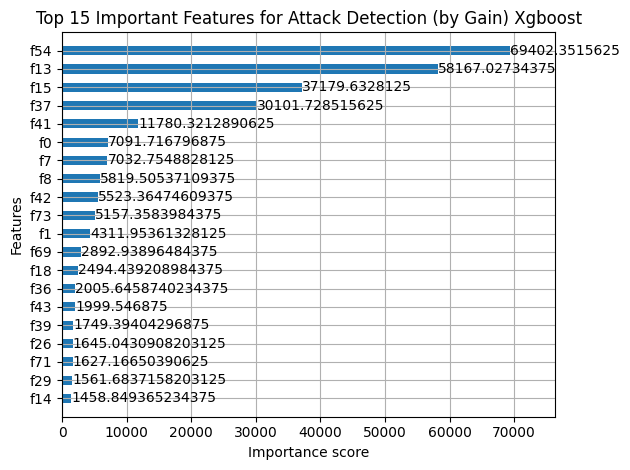

In [12]:
plt.figure(figsize=(12, 6))
plot_importance(xgb, max_num_features=20, height=0.5, importance_type='gain')
plt.title("Top 15 Important Features for Attack Detection (by Gain) Xgboost")
plt.tight_layout()
plt.show()

**Evaluation**

<Figure size 1200x600 with 0 Axes>

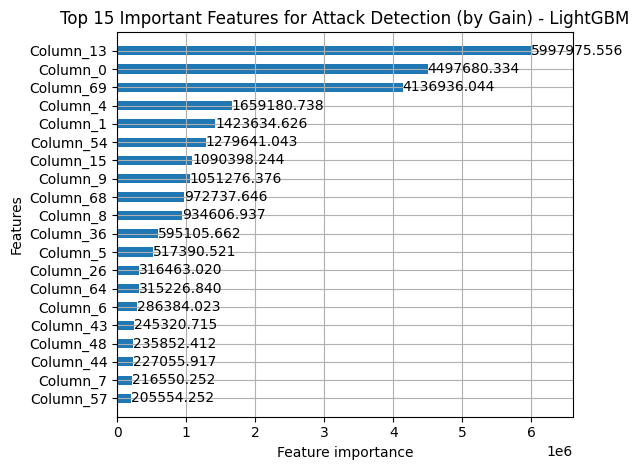

In [13]:
import lightgbm as lgb
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
lgb.plot_importance(lgbm_model,
                    max_num_features=20,
                    height=0.5,
                    importance_type='gain')
plt.title("Top 15 Important Features for Attack Detection (by Gain) - LightGBM")
plt.tight_layout()
plt.show()

/tmp/ipython-input-14-3165352512.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='Importance', y='Feature', palette='viridis')


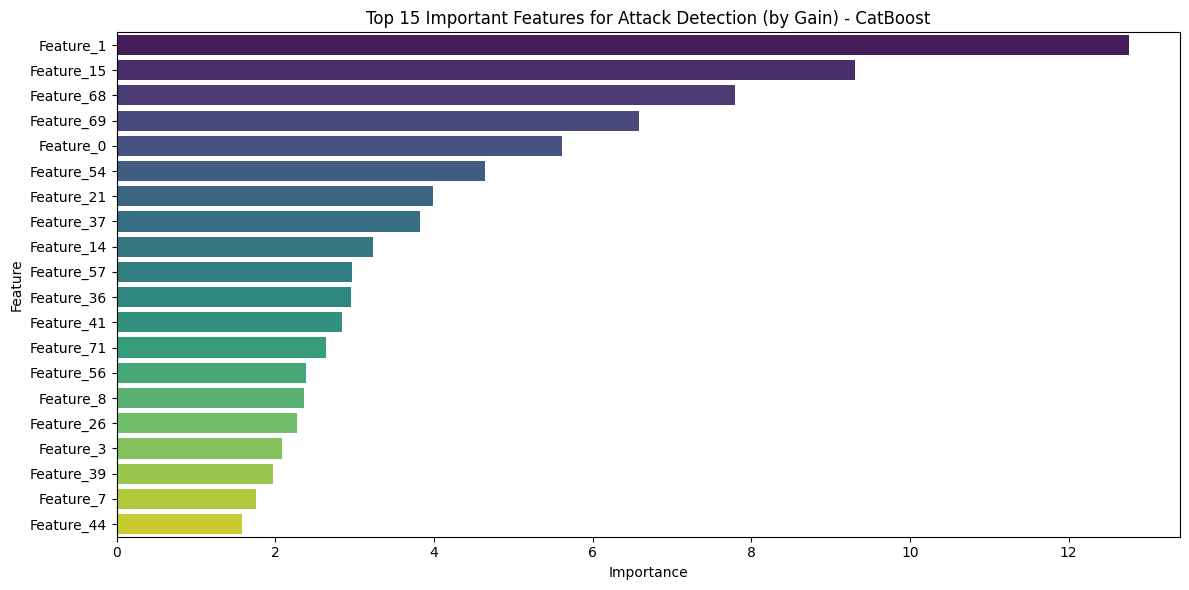

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get importances
importances = cat_model.get_feature_importance()

# Fix for NumPy input
feature_names = [f"Feature_{i}" for i in range(X_train.shape[1])]

# Create DataFrame
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Top 15
top_features = feat_imp_df.sort_values(by='Importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=top_features, x='Importance', y='Feature', palette='viridis')
plt.title("Top 15 Important Features for Attack Detection (by Gain) - CatBoost")
plt.tight_layout()
plt.show()


In [15]:
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

print("Classification Report(xgboost):\n", classification_report(y_test, y_pred_xgb))

Classification Report(xgboost):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    681396
           1       1.00      1.00      1.00    166967

    accuracy                           1.00    848363
   macro avg       1.00      1.00      1.00    848363
weighted avg       1.00      1.00      1.00    848363



In [16]:
y_pred_lgbm = lgbm_model.predict(X_test)
y_proba_lgbm = lgbm_model.predict_proba(X_test)[:, 1]

print("Classification Report(lightGBM):\n", classification_report(y_test, y_pred_lgbm))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Classification Report(lightGBM):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    681396
           1       1.00      1.00      1.00    166967

    accuracy                           1.00    848363
   macro avg       1.00      1.00      1.00    848363
weighted avg       1.00      1.00      1.00    848363



In [17]:
y_pred_cat = cat_model.predict(X_test)
y_proba_cat = cat_model.predict_proba(X_test)[:, 1]

print("Classification Report(catBoost):\n", classification_report(y_test, y_pred_cat))

Classification Report(catBoost):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    681396
           1       1.00      1.00      1.00    166967

    accuracy                           1.00    848363
   macro avg       1.00      1.00      1.00    848363
weighted avg       1.00      1.00      1.00    848363



**Confusion matrix**

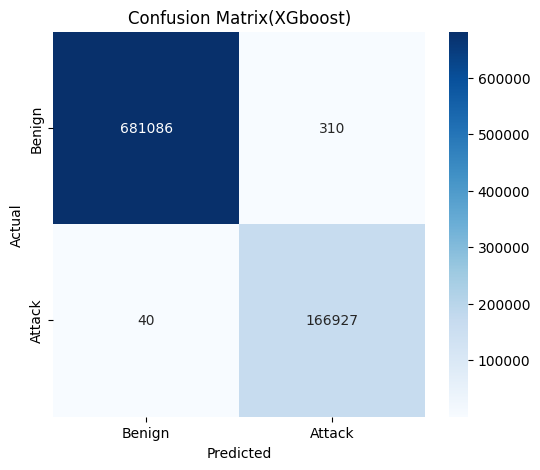

In [18]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap="Blues", xticklabels=["Benign", "Attack"], yticklabels=["Benign", "Attack"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix(XGboost)")
plt.show()


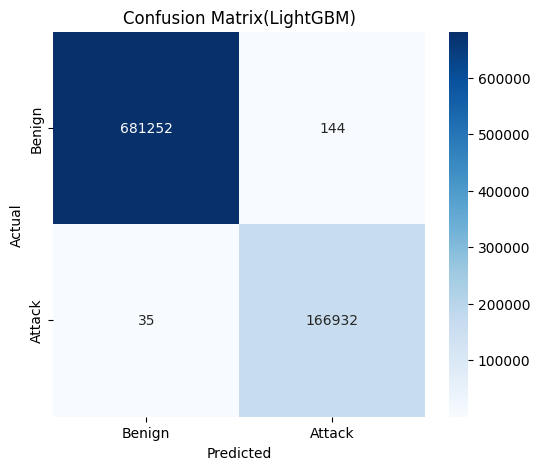

In [19]:
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap="Blues", xticklabels=["Benign", "Attack"], yticklabels=["Benign", "Attack"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix(LightGBM)")
plt.show()

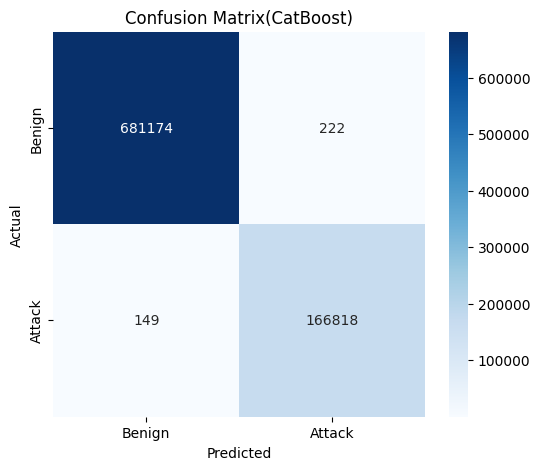

In [20]:
cm_cat = confusion_matrix(y_test, y_pred_cat)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_cat, annot=True, fmt='d', cmap="Blues", xticklabels=["Benign", "Attack"], yticklabels=["Benign", "Attack"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix(CatBoost)")
plt.show()

**ROC Curve**

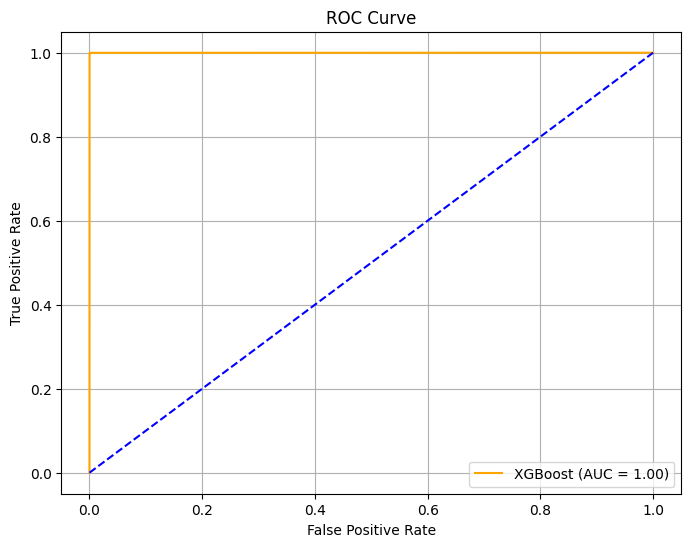

In [21]:
fpr_xgb, tpr_xgb, _xgb = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})', color='orange')
plt.plot([0, 1], [0, 1], linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

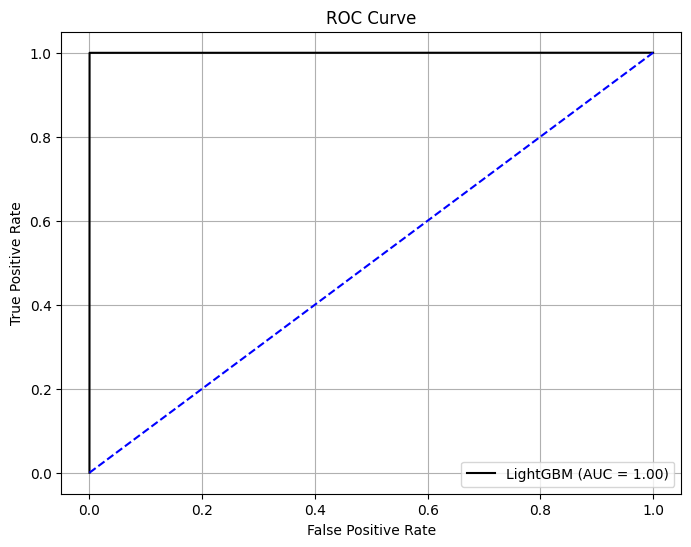

In [22]:
fpr_lgbm, tpr_lgbm, _lgbm = roc_curve(y_test, y_proba_lgbm)
roc_auc_lgbm = auc(fpr_lgbm, tpr_lgbm)
plt.figure(figsize=(8, 6))
plt.plot(fpr_lgbm, tpr_lgbm, label=f'LightGBM (AUC = {roc_auc_lgbm:.2f})', color='black')
plt.plot([0, 1], [0, 1], linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

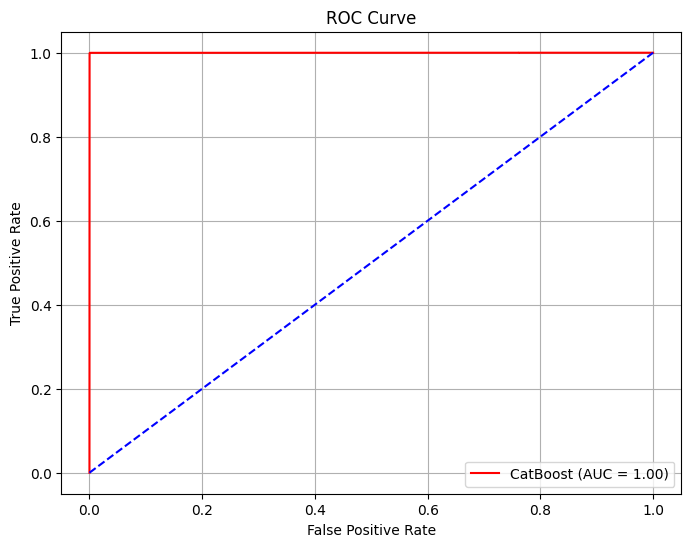

In [23]:
fpr_cat, tpr_cat, _cat = roc_curve(y_test, y_proba_cat)
roc_auc_cat = auc(fpr_cat, tpr_cat)
plt.figure(figsize=(8, 6))
plt.plot(fpr_cat, tpr_cat, label=f'CatBoost (AUC = {roc_auc_cat:.2f})', color='red')
plt.plot([0, 1], [0, 1], linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
from sklearn.metrics import accuracy_score


accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
accuracy_cat = accuracy_score(y_test, y_pred_cat)
print(f"Accuracy of the XGBoost model: {accuracy_xgb * 100:.2f}%")
print(f"Accuracy of the LightGBM model: {accuracy_lgbm * 100:.2f}%")
print(f"Accuracy of the CatBoost model: {accuracy_cat * 100:.2f}%")


Accuracy of the XGBoost model: 99.96%
Accuracy of the LightGBM model: 99.98%
Accuracy of the CatBoost model: 99.96%


/tmp/ipython-input-25-3581448806.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=acc_df, x='Model', y='Accuracy', palette='viridis')


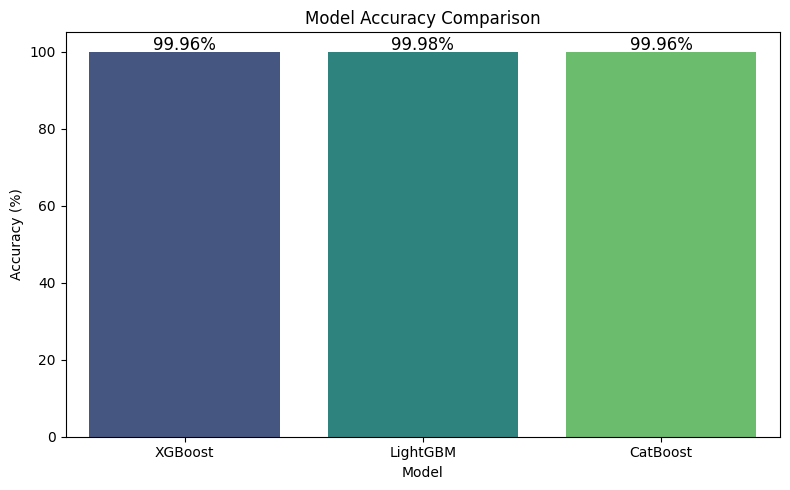

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns


accuracy_scores = {
    'XGBoost': accuracy_xgb,
    'LightGBM': accuracy_lgbm,
    'CatBoost': accuracy_cat
}


import pandas as pd
acc_df = pd.DataFrame(list(accuracy_scores.items()), columns=['Model', 'Accuracy'])


acc_df['Accuracy'] = acc_df['Accuracy'] * 100

plt.figure(figsize=(8, 5))
sns.barplot(data=acc_df, x='Model', y='Accuracy', palette='viridis')


for i, row in acc_df.iterrows():
    plt.text(i, row['Accuracy'] + 0.5, f"{row['Accuracy']:.2f}%", ha='center', fontsize=12)

plt.ylim(0, 105)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.xlabel("Model")
plt.tight_layout()
plt.show()


In [26]:
import time

# XGBoost
start_xgb = time.time()
xgb.fit(X_train, y_train)
end_xgb = time.time()
xgb_time = end_xgb - start_xgb

# LightGBM
start_lgbm = time.time()
lgbm_model.fit(X_train, y_train)
end_lgbm = time.time()
lgbm_time = end_lgbm - start_lgbm

# CatBoost
start_cat = time.time()
cat_model.fit(X_train, y_train, verbose=0)
end_cat = time.time()
cat_time = end_cat - start_cat



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:27:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 389589, number of negative: 1589924
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.800438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14854
[LightGBM] [Info] Number of data points in the train set: 1979513, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/tmp/ipython-input-27-1196787764.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=time_df, x='Model', y='Train Time (s)', palette='magma')


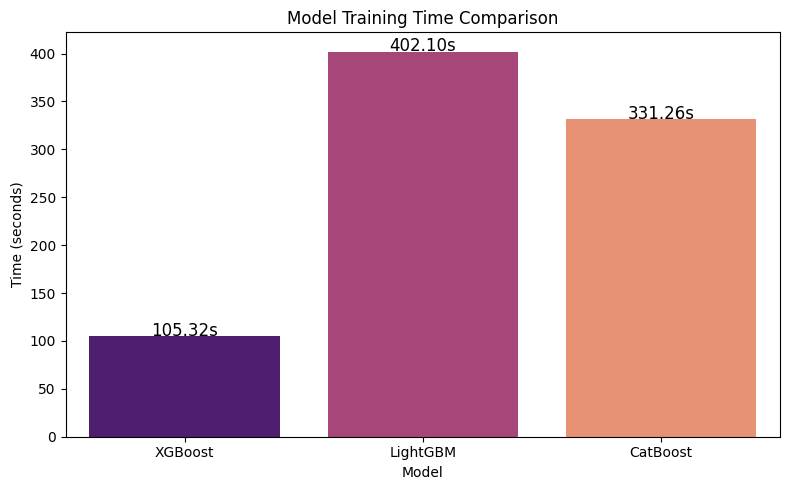

In [27]:
# Create dataframe
train_times = {
    'XGBoost': xgb_time,
    'LightGBM': lgbm_time,
    'CatBoost': cat_time
}

time_df = pd.DataFrame(list(train_times.items()), columns=['Model', 'Train Time (s)'])

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=time_df, x='Model', y='Train Time (s)', palette='magma')

# Annotate time values on bars
for i, row in time_df.iterrows():
    plt.text(i, row['Train Time (s)'] + 0.1, f"{row['Train Time (s)']:.2f}s", ha='center', fontsize=12)

plt.title("Model Training Time Comparison")
plt.ylabel("Time (seconds)")
plt.xlabel("Model")
plt.tight_layout()
plt.show()

In [41]:
import pandas as pd

# Replace this with your actual dataset URL
url = 'https://drive.google.com/file/d/12dQPcqRDJFeJGmqqshzdYN8M5t5tMXbQ/view'

# Load the dataset directly from the URL
df = pd.read_csv(url)

# Display first few rows
df.head()


ParserError: Error tokenizing data. C error: Expected 1 fields in line 3, saw 3547


In [36]:
import pandas as pd

unsw_columns = [
    'srcip', 'sport', 'dsport', 'proto', 'state', 'dur', 'sbytes', 'dbytes', 'sttl',
    'dttl', 'sloss', 'dloss', 'service', 'Sload', 'Dload', 'Spkts', 'Dpkts', 'swin',
    'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len',
    'Sjit', 'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack',
    'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd',
    'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm',
    'ct_src_ ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
    'attack_cat', 'label'
]
selected_indices = [1,15,68,69,0,13,54,15,37,41,7,8,69,4,1,54,15,9,21,37,14,57,36,42,73,18,26,6]
unique_indices = sorted(set(selected_indices))

selected_unsw_columns = [unsw_columns[i] for i in unique_indices]


IndexError: list index out of range

In [30]:
X_unsw_test = unsw_test_mapped.drop(columns=['Label'], errors='ignore')

y_unsw_test = unsw_test_mapped['Label'] if 'Label' in unsw_test_mapped.columns else None


In [31]:
from sklearn.preprocessing import LabelEncoder


X_unsw_test_encoded = X_unsw_test.copy()


label_encoders = {}
for col in X_unsw_test_encoded.columns:
    if X_unsw_test_encoded[col].dtype == 'object':
        le = LabelEncoder()
        X_unsw_test_encoded[col] = le.fit_transform(X_unsw_test_encoded[col].astype(str))
        label_encoders[col] = le


In [33]:
# XGBoost
y_pred_xgb = xgb.predict(X_unsw_test_encoded)

# LightGBM
y_pred_lgbm = lgbm_model.predict(X_unsw_test_encoded)

# CatBoost (CatBoost can handle raw categorical, but works fine with label-encoded too)
y_pred_cat = cat_model.predict(X_unsw_test_encoded)



ValueError: Feature shape mismatch, expected: 80, got 9